Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ 10 epoch부터 학습 재개


Epoch [11/20]:  19%|█▉        | 37/191 [12:32<47:23, 18.46s/it, loss=0.426]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch [11/20]: 100%|██████████| 191/191 [1:05:26<00:00, 20.56s/it, loss=0.428]


💾 체크포인트 저장 완료: epoch 11


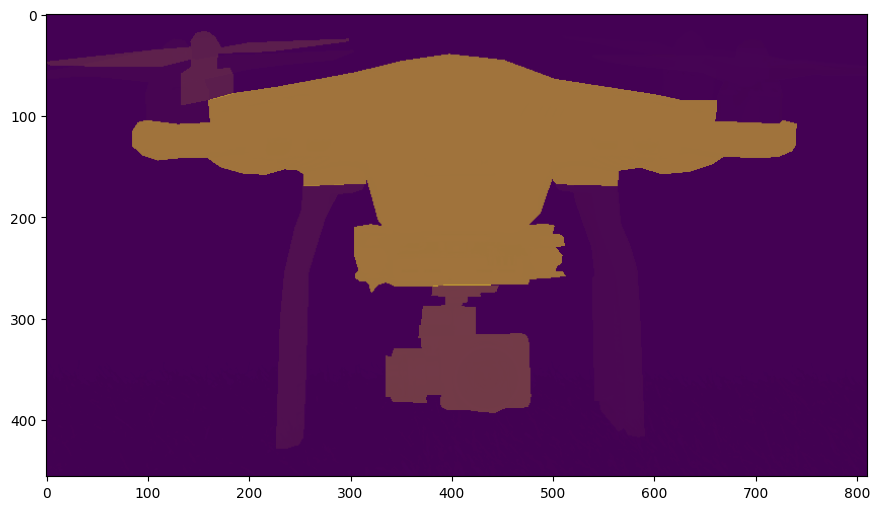

Epoch [12/20]: 100%|██████████| 191/191 [1:01:55<00:00, 19.45s/it, loss=0.723]


💾 체크포인트 저장 완료: epoch 12


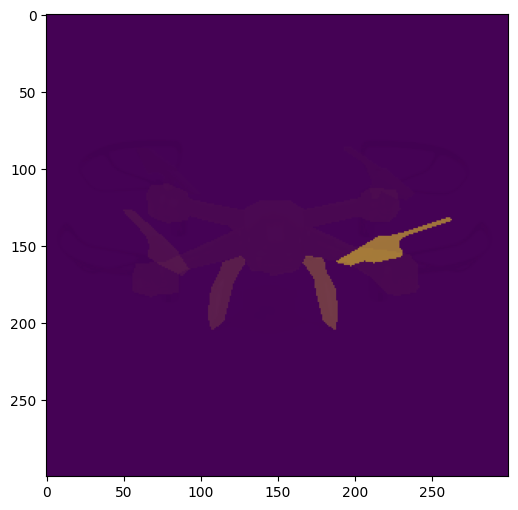

Epoch [13/20]: 100%|██████████| 191/191 [1:01:45<00:00, 19.40s/it, loss=0.338]


💾 체크포인트 저장 완료: epoch 13


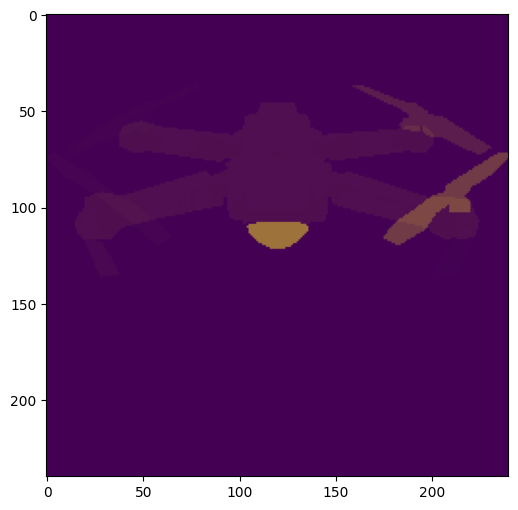

Epoch [14/20]: 100%|██████████| 191/191 [1:01:45<00:00, 19.40s/it, loss=0.995]


💾 체크포인트 저장 완료: epoch 14


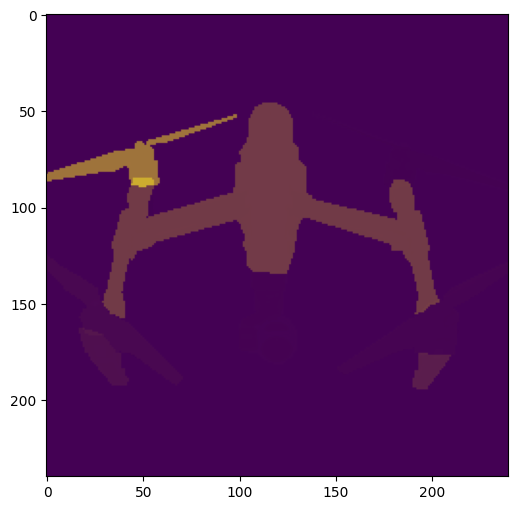

Epoch [15/20]: 100%|██████████| 191/191 [1:01:40<00:00, 19.37s/it, loss=0.7]


💾 체크포인트 저장 완료: epoch 15


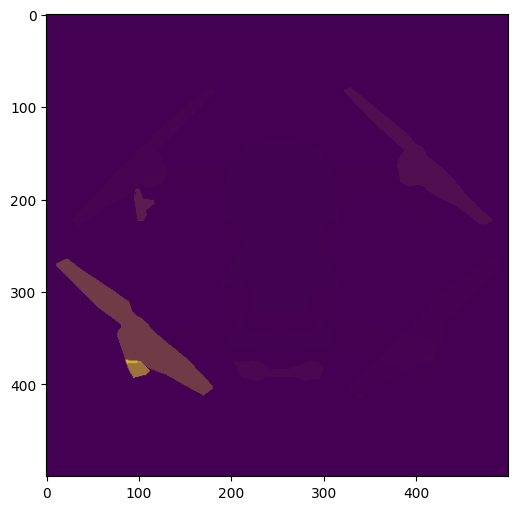

Epoch [16/20]: 100%|██████████| 191/191 [1:01:21<00:00, 19.27s/it, loss=0.573]


💾 체크포인트 저장 완료: epoch 16


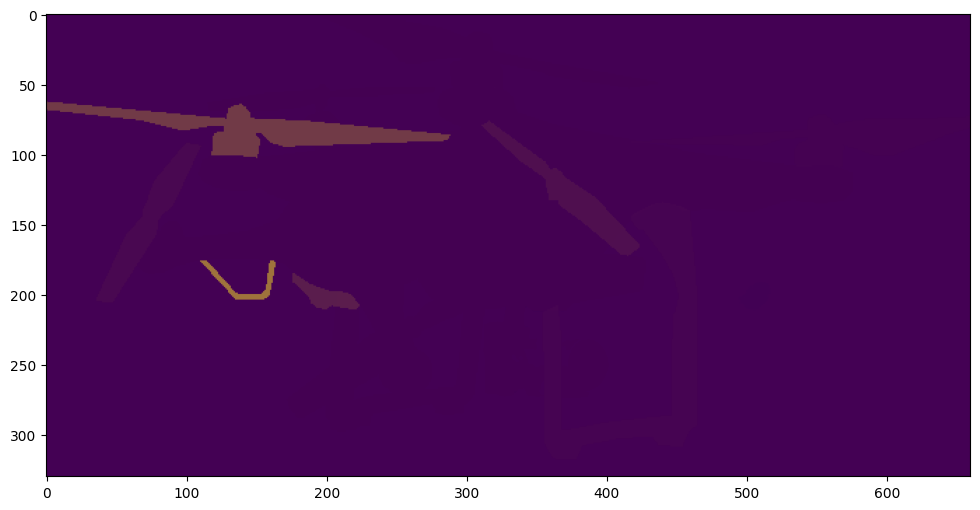

Epoch [17/20]: 100%|██████████| 191/191 [1:01:19<00:00, 19.26s/it, loss=0.464]


💾 체크포인트 저장 완료: epoch 17


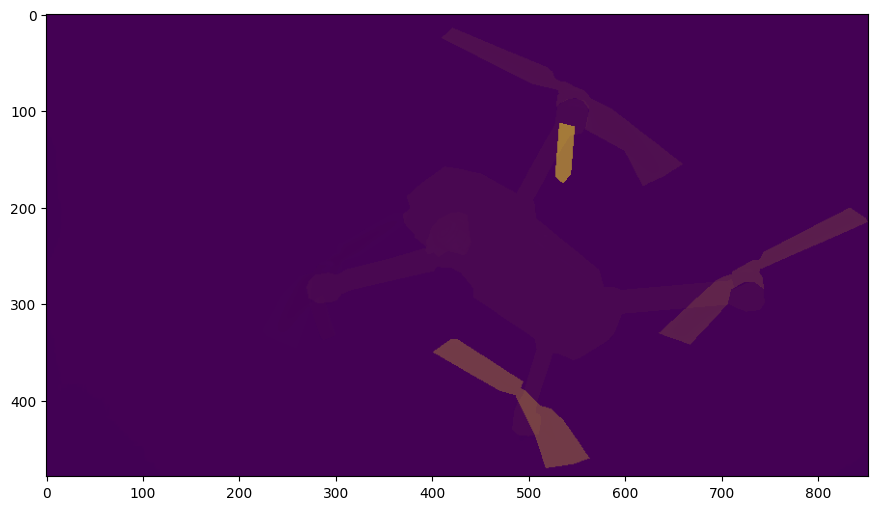

Epoch [18/20]: 100%|██████████| 191/191 [1:01:15<00:00, 19.24s/it, loss=0.409]


💾 체크포인트 저장 완료: epoch 18


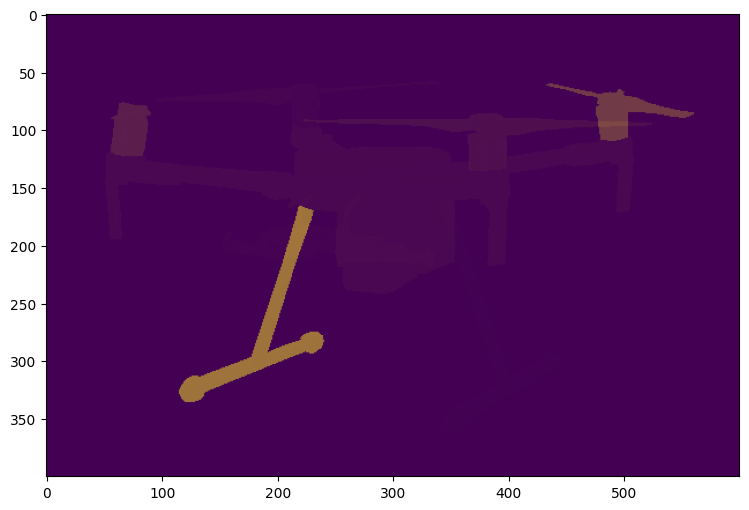

Epoch [19/20]: 100%|██████████| 191/191 [1:01:07<00:00, 19.20s/it, loss=0.866]


💾 체크포인트 저장 완료: epoch 19


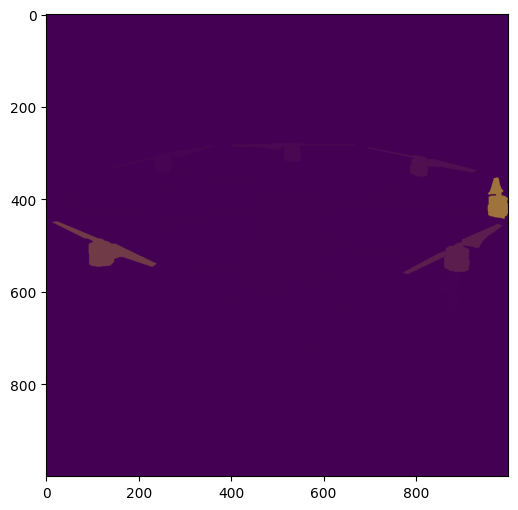

Epoch [20/20]: 100%|██████████| 191/191 [1:00:40<00:00, 19.06s/it, loss=0.486]


💾 체크포인트 저장 완료: epoch 20


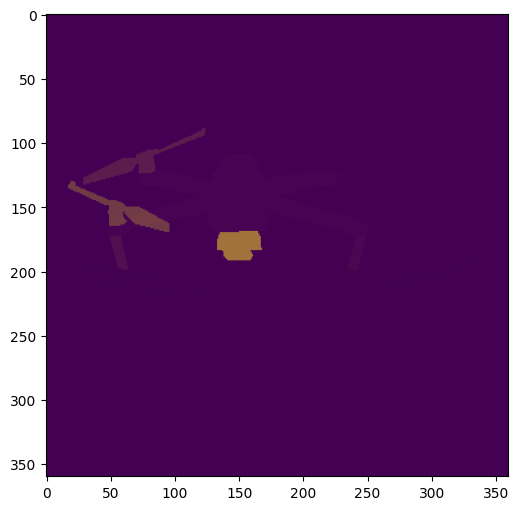

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import json
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.transforms import functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
from pycocotools import mask as maskUtils

IMG_DIR = "/content/drive/MyDrive/images"
JSON_PATH = "/content/drive/MyDrive/annotations.json"
CHECKPOINT_DIR = "/content/drive/MyDrive/mask_rcnn_checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

def polygon_to_mask(segmentation, height, width):
    rle = maskUtils.frPyObjects(segmentation, height, width)
    mask = maskUtils.decode(rle)
    if len(mask.shape) == 3:  # 여러 mask 합치기
        mask = np.any(mask, axis=2)
    return mask.astype(np.uint8)

class DroneCocoDataset(Dataset):
    def __init__(self, root, ann_file, transforms=None):
        self.root = root
        self.transforms = transforms
        with open(ann_file) as f:
            coco = json.load(f)
        self.images = coco["images"]
        self.annotations = coco["annotations"]
        self.img_id_to_ann = {}
        for ann in self.annotations:
            self.img_id_to_ann.setdefault(ann["image_id"], []).append(ann)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_info = self.images[idx]
        img_path = os.path.join(self.root, img_info["file_name"])
        img = Image.open(img_path).convert("RGB")

        anns = self.img_id_to_ann.get(img_info["id"], [])
        boxes, labels, masks = [], [], []

        for ann in anns:
            x, y, w, h = ann["bbox"]
            boxes.append([x, y, x+w, y+h])
            labels.append(ann["category_id"])

            if "segmentation" in ann and ann["segmentation"]:
                mask = polygon_to_mask(ann["segmentation"], img.height, img.width)
            else:
                mask = np.zeros((img.height, img.width), dtype=np.uint8)
            masks.append(mask)

        if len(boxes) == 0:  # 객체 없는 이미지 예외 처리
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
            masks = torch.zeros((0, img.height, img.width), dtype=torch.uint8)
        else:
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)
            masks = torch.as_tensor(np.stack(masks), dtype=torch.uint8)

        target = {"boxes": boxes, "labels": labels, "masks": masks}

        if self.transforms:
            img = self.transforms(img)

        return img, target

def get_transform(train=True):
    def _transform(img):
        img = F.to_tensor(img)
        return img
    return _transform

dataset = DroneCocoDataset(root=IMG_DIR, ann_file=JSON_PATH, transforms=get_transform())
data_loader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

num_classes = 5
model = maskrcnn_resnet50_fpn(weights="COCO_V1", progress=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# 체크포인트 재개
start_epoch = 0
checkpoint_path = os.path.join(CHECKPOINT_DIR, "latest.pth")
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    lr_scheduler.load_state_dict(checkpoint["scheduler_state_dict"])
    start_epoch = checkpoint["epoch"] + 1
    print(f" {start_epoch} epoch부터 학습 재개")

num_epochs = 20
for epoch in range(start_epoch, num_epochs):
    model.train()
    loop = tqdm(data_loader, total=len(data_loader))
    for images, targets in loop:
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
        loop.set_postfix(loss=losses.item())

    lr_scheduler.step()

    ckpt_path_epoch = os.path.join(CHECKPOINT_DIR, f"epoch{epoch+1}.pth")
    torch.save({
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "scheduler_state_dict": lr_scheduler.state_dict()
    }, ckpt_path_epoch)
    torch.save({
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "scheduler_state_dict": lr_scheduler.state_dict()
    }, checkpoint_path)
    print(f"체크포인트 저장 완료: epoch {epoch+1}")

    # GT 마스크 시각화
    model.eval()
    imgs, tgts = next(iter(data_loader))
    fig, ax = plt.subplots(1, len(imgs), figsize=(12, 6))
    for i, img in enumerate(imgs):
        img_np = img.permute(1,2,0).numpy()
        ax.imshow(img_np)
        for mask in tgts[i]["masks"]:
            ax.imshow(mask.cpu(), alpha=0.5)
    plt.show()
    model.train()


In [ ]:
import os
import json
import numpy as np
import random
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.transforms import functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
from pycocotools import mask as maskUtils


IMG_DIR = "/content/drive/MyDrive/images"
JSON_PATH = "/content/drive/MyDrive/annotations.json"
CHECKPOINT_DIR = "/content/drive/MyDrive/mask_rcnn_checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using device: {device}")

# 증강
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

class ToTensor(object):
    def __call__(self, image, target):
        image = F.to_tensor(image)
        return image, target

class RandomHorizontalFlip(object):
    def __init__(self, prob=0.5):
        self.prob = prob

    def __call__(self, image, target):
        if random.random() < self.prob:
            height, width = image.shape[-2:]
            image = image.flip(-1) # 이미지 좌우 반전

            bbox = target["boxes"]
            # BBox 좌표 반전: [x_min, y_min, x_max, y_max] -> [w - x_max, y_min, w - x_min, y_max]
            bbox[:, [0, 2]] = width - bbox[:, [2, 0]]
            target["boxes"] = bbox

            if "masks" in target:
                target["masks"] = target["masks"].flip(-1) # 마스크 좌우 반전

        return image, target

def get_transform(train):
    transforms = []
    transforms.append(ToTensor())
    if train:
        # 학습 시에만 랜덤 뒤집기 적용 (데이터 증강)
        transforms.append(RandomHorizontalFlip(0.5))
    return Compose(transforms)

def polygon_to_mask(segmentation, height, width):
    rle = maskUtils.frPyObjects(segmentation, height, width)
    mask = maskUtils.decode(rle)
    if len(mask.shape) == 3:
        mask = np.any(mask, axis=2)
    return mask.astype(np.uint8)

# 데이터셋 정의
class DroneCocoDataset(Dataset):
    def __init__(self, root, ann_file, transforms=None):
        self.root = root
        self.transforms = transforms
        with open(ann_file) as f:
            coco = json.load(f)
        self.images = coco["images"]
        self.annotations = coco["annotations"]
        self.img_id_to_ann = {}
        for ann in self.annotations:
            self.img_id_to_ann.setdefault(ann["image_id"], []).append(ann)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_info = self.images[idx]
        img_path = os.path.join(self.root, img_info["file_name"])
        img = Image.open(img_path).convert("RGB")

        anns = self.img_id_to_ann.get(img_info["id"], [])
        boxes, labels, masks = [], [], []

        for ann in anns:
            x, y, w, h = ann["bbox"]
            boxes.append([x, y, x+w, y+h])
            labels.append(ann["category_id"])

            if "segmentation" in ann and ann["segmentation"]:
                mask = polygon_to_mask(ann["segmentation"], img.height, img.width)
            else:
                mask = np.zeros((img.height, img.width), dtype=np.uint8)
            masks.append(mask)

        if len(boxes) == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
            masks = torch.zeros((0, img.height, img.width), dtype=torch.uint8)
        else:
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)
            masks = torch.as_tensor(np.stack(masks), dtype=torch.uint8)

        target = {"boxes": boxes, "labels": labels, "masks": masks}

        if self.transforms:
            img, target = self.transforms(img, target)

        return img, target

# 데이터 로드
full_dataset = DroneCocoDataset(root=IMG_DIR, ann_file=JSON_PATH, transforms=get_transform(train=True))
full_dataset_test = DroneCocoDataset(root=IMG_DIR, ann_file=JSON_PATH, transforms=get_transform(train=False))

# 데이터셋 분할
torch.manual_seed(42)
indices = torch.randperm(len(full_dataset)).tolist()
test_split = int(0.2 * len(full_dataset))
train_dataset = torch.utils.data.Subset(full_dataset, indices[:-test_split])
val_dataset = torch.utils.data.Subset(full_dataset_test, indices[-test_split:])

print(f"Total Images: {len(full_dataset)}")
print(f"Training: {len(train_dataset)}, Validation: {len(val_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=2, collate_fn=lambda x: tuple(zip(*x)))

# 모델 정의
num_classes = 5
model = maskrcnn_resnet50_fpn(weights="COCO_V1")

in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

model.to(device)

# 학습&검증
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# 검증 손실 계산 함수
def validate_loss(model, data_loader, device):

    model.train()
    total_loss = 0
    with torch.no_grad():
        for images, targets in data_loader:
            images = list(img.to(device) for img in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            total_loss += losses.item()
    return total_loss / len(data_loader)


#학습 루프
num_epochs = 20
best_val_loss = float('inf')

print("Start Training...")
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    loop = tqdm(train_loader, total=len(train_loader))
    for images, targets in loop:
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        train_loss += losses.item()
        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
        loop.set_postfix(loss=losses.item())

    avg_train_loss = train_loss / len(train_loader)

    # 검증
    avg_val_loss = validate_loss(model, val_loader, device)

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    lr_scheduler.step()

    # Best Model 저장
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), os.path.join(CHECKPOINT_DIR, "best_model.pth"))
        print(f"Best model saved! (Val Loss: {best_val_loss:.4f})")

    # 체크포인트 저장
    torch.save({
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "loss": avg_train_loss,
    }, os.path.join(CHECKPOINT_DIR, "latest.pth"))

print("학습 완료.")